# Testing Tenor Log Mel Spectrogram with Convolutional Neural Network

Here we test a convolutional neural network on log Mel spectrogram data extracted from our WAV samles. Each log Mel spectrogram has 96 x 96 = 9,216 features, where 96 is the number of frequency bands, and 96 is the number of time slices (collections of 2,297 raw samples). So this is a lot of data.

Upstream from this notebook we extracted these features and saved them as pickles, then we read all the pickles and aggregated them into a Pandas DataFrame, again saved as a pickle. Finally, with the imported `_tenor_lms` (below) we read from this pickle, filter and reshape the data as needed, and then we scale data using `sklearn.preprocessing.StandardScaler`. At this point, data are ready to read into our notebook.

In this notebook we define, train, and test a CNN with these log Mel spectrogram data as input.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, \
    Conv2D, MaxPooling2D, AveragePooling2D
from keras.metrics import AUC, Recall
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from _common import NUM_LABEL_COLS, RANDOM_SEED
from _tenor_lmsc import TEST_SIZE, VALIDATION_SIZE, \
    BANDS, TIME_SLICES, master, lmss, data, target
# Note that records are read from pickle, selected, filtered,
# and scaled with `sklearn.preprocessing.StandardScaler` 
# in `_tenor_lmsc.py`.

In [3]:
x_train, x_test, y_train, y_test = \
     train_test_split(data, target,
                      test_size=TEST_SIZE,
                      random_state=RANDOM_SEED)

In [4]:
# Reshape for input to 2D convolutional layer
x_train = x_train.reshape(x_train.shape[0], BANDS, TIME_SLICES, 1)
x_test = x_test.reshape(x_test.shape[0], BANDS, TIME_SLICES, 1)

# Train the CNN
This may take between 5 and 7 minutes per epoch

# Model A

In [63]:
NUM_EPOCHS = 3
BATCH_SIZE = 32
INPUT_SHAPE = (BANDS, TIME_SLICES, 1)

# https://www.tensorflow.org/tutorials/images/cnn
# https://keras.io/api/layers/convolution_layers/convolution2d/
# https://keras.io/api/layers/pooling_layers/max_pooling2d/
# https://keras.io/api/layers/reshaping_layers/flatten/
# https://keras.io/api/layers/core_layers/dense/
# Architecture based in part on 
#   https://www.kaggle.com/ashirahama/simple-keras-cnn-with-mfcc
model = Sequential()
# Conv2D (from the docs)
# 2D convolution layer (e.g. spatial convolution over images).
# This layer creates a convolution kernel that is convolved with 
# the layer input to produce a tensor of outputs. 
model.add(Conv2D(32, kernel_size=(2, 2), activation='relu',
                 input_shape=INPUT_SHAPE))
model.add(Conv2D(48, kernel_size=(2, 2), activation='relu'))
model.add(Conv2D(128, kernel_size=(2, 2), activation='relu'))
# MaxPooling2D (from the docs)
# "Downsamples the input representation by taking the maximum value over the 
# window defined by pool_size for each dimension along the features axis. 
# The window is shifted by strides in each dimension. The resulting output 
# when using "valid" padding option has a shape (number of rows or columns) 
# of: output_shape = (input_shape - pool_size + 1) / strides)""
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())  # Flattens the input. Does not affect the batch size.
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', 
              metrics=[Recall(name='recall'), 'accuracy'])
history = model.fit(x_train, y_train, epochs=NUM_EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    validation_split=VALIDATION_SIZE)

Train on 3620 samples, validate on 906 samples
Epoch 1/3
3620/3620 [==============================] - 224s 62ms/step - loss: 0.6254 - recall: 0.7844 - accuracy: 0.7486 - val_loss: 0.3164 - val_recall: 0.7721 - val_accuracy: 0.8598
Epoch 2/3
3620/3620 [==============================] - 199s 55ms/step - loss: 0.3044 - recall: 0.8605 - accuracy: 0.8801 - val_loss: 0.2506 - val_recall: 0.9446 - val_accuracy: 0.9161
Epoch 3/3
3620/3620 [==============================] - 245s 68ms/step - loss: 0.1825 - recall: 0.9297 - accuracy: 0.9348 - val_loss: 0.2242 - val_recall: 0.9240 - val_accuracy: 0.9183


In [64]:
# auc, 
loss, recall, accuracy = model.evaluate(x_test, y_test)
# print('AUC: %.2f' % (auc * 100))
print('Recall: %.2f' % (recall * 100))
print('Accuracy: %.2f' % (accuracy * 100))
# @ 3 Epochs
# Recall: 91.99
# Accuracy: 90.90
# @ 6 Epochs
# Recall: 91.34
# Accuracy: 90.11

1132/1132 [==============================] - 16s 14ms/step
Recall: 91.99
Accuracy: 90.90


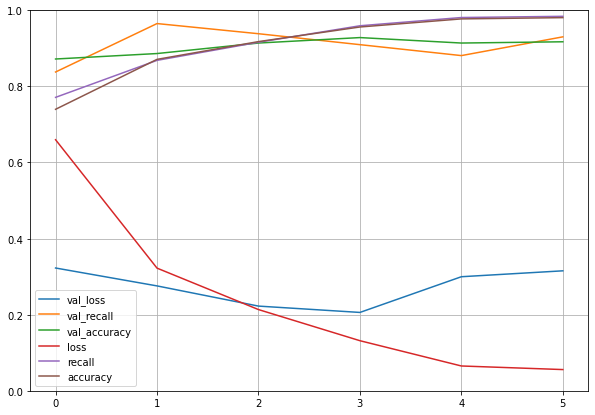

In [49]:
# history is a keras.callbacks.callbacks.History object
pd.DataFrame(history.history).plot(figsize=(10, 7))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()


In [16]:
# DON'T RE-RUN .... YET
NUM_EPOCHS = 3
BATCH_SIZE = 32
INPUT_SHAPE = (BANDS, TIME_SLICES, 1)

model = Sequential()
model.add(Conv2D(64, kernel_size=(2, 2), activation='relu',
                 input_shape=INPUT_SHAPE))
model.add(Conv2D(64, kernel_size=(2, 2), activation='relu'))
model.add(Conv2D(128, kernel_size=(2, 2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())  # Flattens the input. Does not affect the batch size.
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', 
              metrics=[Recall(name='recall'), 'accuracy'])
history = model.fit(x_train, y_train, epochs=NUM_EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    validation_split=VALIDATION_SIZE)

Train on 3620 samples, validate on 906 samples
Epoch 1/3
3620/3620 [==============================] - 279s 77ms/step - loss: 0.5723 - recall: 0.7727 - accuracy: 0.7682 - val_loss: 0.2867 - val_recall: 0.8480 - val_accuracy: 0.8841
Epoch 2/3
3620/3620 [==============================] - 285s 79ms/step - loss: 0.3030 - recall: 0.8742 - accuracy: 0.8848 - val_loss: 0.3074 - val_recall: 0.7906 - val_accuracy: 0.8687
Epoch 3/3
1132/1132 [==============================] - 15s 14ms/step


ValueError: too many values to unpack (expected 2)

In [17]:
# auc, 
loss, recall, accuracy = model.evaluate(x_test, y_test)
# print('AUC: %.2f' % (auc * 100))
print('Recall: %.2f' % (recall * 100))
print('Accuracy: %.2f' % (accuracy * 100))

1132/1132 [==============================] - 13s 11ms/step
Recall: 84.97
Accuracy: 89.84


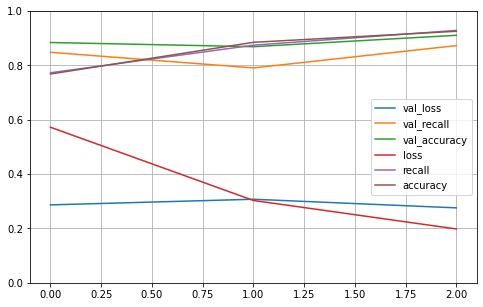

In [18]:
# history is a keras.callbacks.callbacks.History object
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()


In [20]:
# DON'T RE-RUN
NUM_EPOCHS = 3
BATCH_SIZE = 32
INPUT_SHAPE = (BANDS, TIME_SLICES, 1)

model = Sequential()
model.add(Conv2D(32, kernel_size=(2, 2), activation='relu',
                 input_shape=INPUT_SHAPE))
model.add(Conv2D(48, kernel_size=(2, 2), activation='relu'))
model.add(Conv2D(128, kernel_size=(2, 2), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))
model.add(Flatten())  # Flattens the input. Does not affect the batch size.
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', 
              metrics=[Recall(name='recall'), 'accuracy'])
history = model.fit(x_train, y_train, epochs=NUM_EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    validation_split=VALIDATION_SIZE)

Train on 3620 samples, validate on 906 samples
Epoch 1/3
3620/3620 [==============================] - 460s 127ms/step - loss: 0.9299 - recall: 0.7558 - accuracy: 0.7122 - val_loss: 0.3865 - val_recall: 0.9117 - val_accuracy: 0.8587
Epoch 2/3
3620/3620 [==============================] - 450s 124ms/step - loss: 0.3635 - recall: 0.8356 - accuracy: 0.8506 - val_loss: 0.3087 - val_recall: 0.8850 - val_accuracy: 0.8819
Epoch 3/3
3620/3620 [==============================] - 451s 125ms/step - loss: 0.2276 - recall: 0.9027 - accuracy: 0.9116 - val_loss: 0.2963 - val_recall: 0.8706 - val_accuracy: 0.8852


In [22]:
# auc, 
loss, recall, accuracy = model.evaluate(x_test, y_test)
# print('AUC: %.2f' % (auc * 100))
print('Recall: %.2f' % (recall * 100))
print('Accuracy: %.2f' % (accuracy * 100))

1132/1132 [==============================] - 15s 13ms/step
Recall: 85.13
Accuracy: 86.40


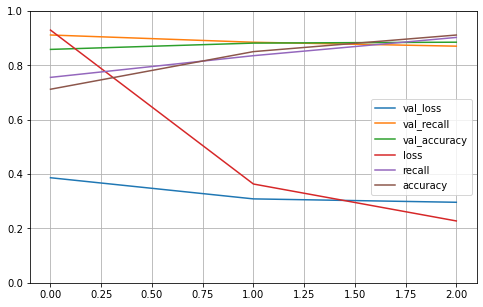

In [23]:
# history is a keras.callbacks.callbacks.History object
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [25]:
# DON'T RE-RUN
NUM_EPOCHS = 3
BATCH_SIZE = 32
INPUT_SHAPE = (BANDS, TIME_SLICES, 1)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu',
                 input_shape=INPUT_SHAPE))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4375))  # 28
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', 
              metrics=[Recall(name='recall'), 'accuracy'])
history = model.fit(x_train, y_train, epochs=NUM_EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    validation_split=VALIDATION_SIZE)

Train on 3620 samples, validate on 906 samples
Epoch 1/3
3620/3620 [==============================] - 630s 174ms/step - loss: 0.5595 - recall: 0.7780 - accuracy: 0.7586 - val_loss: 0.3134 - val_recall: 0.8624 - val_accuracy: 0.8797
Epoch 2/3
3620/3620 [==============================] - 556s 154ms/step - loss: 0.3344 - recall: 0.8446 - accuracy: 0.8718 - val_loss: 0.2333 - val_recall: 0.8871 - val_accuracy: 0.9106
Epoch 3/3
3620/3620 [==============================] - 456s 126ms/step - loss: 0.2724 - recall: 0.8853 - accuracy: 0.9003 - val_loss: 0.2543 - val_recall: 0.9158 - val_accuracy: 0.9095


In [26]:
# auc, 
loss, recall, accuracy = model.evaluate(x_test, y_test)
# print('AUC: %.2f' % (auc * 100))
print('Recall: %.2f' % (recall * 100))
print('Accuracy: %.2f' % (accuracy * 100))

1132/1132 [==============================] - 33s 29ms/step
Recall: 88.73
Accuracy: 88.34


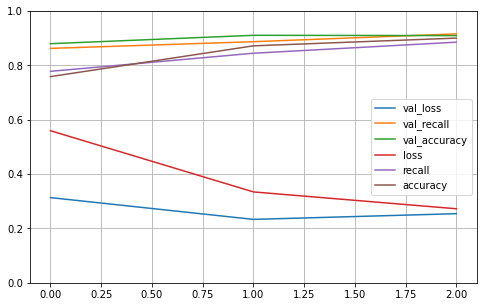

In [27]:
# history is a keras.callbacks.callbacks.History object
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [28]:
# DON'T RE-RUN
NUM_EPOCHS = 3
BATCH_SIZE = 32
INPUT_SHAPE = (BANDS, TIME_SLICES, 1)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu',
                 input_shape=INPUT_SHAPE))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4375))  # 28
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', 
              metrics=[Recall(name='recall'), 'accuracy'])
history = model.fit(x_train, y_train, epochs=NUM_EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    validation_split=VALIDATION_SIZE)

Train on 3620 samples, validate on 906 samples
Epoch 1/3
3620/3620 [==============================] - 283s 78ms/step - loss: 0.5908 - recall: 0.7574 - accuracy: 0.7403 - val_loss: 0.3452 - val_recall: 0.8152 - val_accuracy: 0.8620
Epoch 2/3
3620/3620 [==============================] - 281s 78ms/step - loss: 0.3563 - recall: 0.8383 - accuracy: 0.8552 - val_loss: 0.2793 - val_recall: 0.8460 - val_accuracy: 0.8929
Epoch 3/3
3620/3620 [==============================] - 280s 77ms/step - loss: 0.2717 - recall: 0.8853 - accuracy: 0.8978 - val_loss: 0.2611 - val_recall: 0.8665 - val_accuracy: 0.8985


In [29]:
# auc, 
loss, recall, accuracy = model.evaluate(x_test, y_test)
# print('AUC: %.2f' % (auc * 100))
print('Recall: %.2f' % (recall * 100))
print('Accuracy: %.2f' % (accuracy * 100))

1132/1132 [==============================] - 17s 15ms/step
Recall: 85.29
Accuracy: 89.05


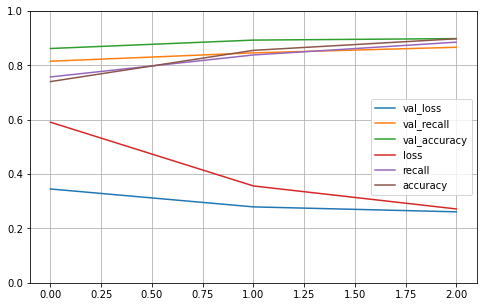

In [30]:
# history is a keras.callbacks.callbacks.History object
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

# Model B

In [65]:
NUM_EPOCHS = 3
BATCH_SIZE = 32
INPUT_SHAPE = (BANDS, TIME_SLICES, 1)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu',
                 input_shape=INPUT_SHAPE))
model.add(Conv2D(48, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(72, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4375))  # 28
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', 
              metrics=[Recall(name='recall'), 'accuracy'])
history = model.fit(x_train, y_train, epochs=NUM_EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    validation_split=VALIDATION_SIZE)

Train on 3620 samples, validate on 906 samples
Epoch 1/3
3620/3620 [==============================] - 391s 108ms/step - loss: 0.5242 - recall: 0.7717 - accuracy: 0.7594 - val_loss: 0.3906 - val_recall: 0.8912 - val_accuracy: 0.8411
Epoch 2/3
3620/3620 [==============================] - 393s 109ms/step - loss: 0.3603 - recall: 0.8319 - accuracy: 0.8536 - val_loss: 0.6137 - val_recall: 0.5791 - val_accuracy: 0.7638
Epoch 3/3
3620/3620 [==============================] - 387s 107ms/step - loss: 0.3097 - recall: 0.8673 - accuracy: 0.8768 - val_loss: 0.2749 - val_recall: 0.8460 - val_accuracy: 0.8885


In [67]:
# auc, 
loss, recall, accuracy = model.evaluate(x_test, y_test)
# print('AUC: %.2f' % (auc * 100))
print('Recall: %.2f' % (recall * 100))
print('Accuracy: %.2f' % (accuracy * 100))
# @ 3 epochs
# Recall: 83.01
# Accuracy: 89.75
# @ 6 epochs
# Recall: 93.30
# Accuracy: 91.52

1132/1132 [==============================] - 12s 11ms/step
Recall: 83.01
Accuracy: 89.75


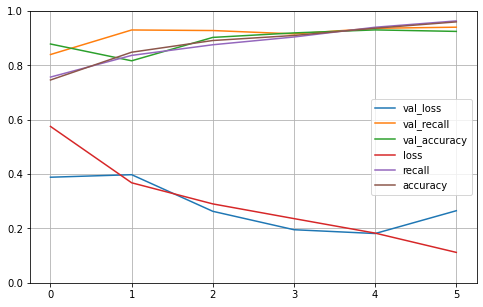

In [52]:
# history is a keras.callbacks.callbacks.History object
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

# Model C

In [53]:
NUM_EPOCHS = 6
BATCH_SIZE = 32
INPUT_SHAPE = (BANDS, TIME_SLICES, 1)

model = Sequential()
model.add(Conv2D(32, kernel_size=(2, 2), activation='relu',
                 input_shape=INPUT_SHAPE))
model.add(Conv2D(48, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(72, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(108, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(108, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(54, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', 
              metrics=[Recall(name='recall'), 'accuracy'])
history = model.fit(x_train, y_train, epochs=NUM_EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    validation_split=VALIDATION_SIZE)

Train on 3620 samples, validate on 906 samples
Epoch 1/6
3620/3620 [==============================] - 383s 106ms/step - loss: 0.5339 - recall: 0.7437 - accuracy: 0.7550 - val_loss: 0.3539 - val_recall: 0.8501 - val_accuracy: 0.8477
Epoch 2/6
3620/3620 [==============================] - 351s 97ms/step - loss: 0.3735 - recall: 0.8187 - accuracy: 0.8428 - val_loss: 0.2549 - val_recall: 0.8953 - val_accuracy: 0.8940
Epoch 3/6
3620/3620 [==============================] - 361s 100ms/step - loss: 0.2785 - recall: 0.8848 - accuracy: 0.8892 - val_loss: 0.2528 - val_recall: 0.9569 - val_accuracy: 0.9029
Epoch 4/6
3620/3620 [==============================] - 351s 97ms/step - loss: 0.2187 - recall: 0.9170 - accuracy: 0.9149 - val_loss: 0.2478 - val_recall: 0.9610 - val_accuracy: 0.9018
Epoch 5/6
3620/3620 [==============================] - 386s 107ms/step - loss: 0.1441 - recall: 0.9493 - accuracy: 0.9459 - val_loss: 0.2313 - val_recall: 0.8706 - val_accuracy: 0.9150
Epoch 6/6
3620/3620 [=========

In [54]:
# auc, 
loss, recall, accuracy = model.evaluate(x_test, y_test)
# print('AUC: %.2f' % (auc * 100))
print('Recall: %.2f' % (recall * 100))
print('Accuracy: %.2f' % (accuracy * 100))
# @ 3 epochs
# Recall: 92.81
# Accuracy: 90.64
# @ 6 epochs
# Recall: 96.08
# Accuracy: 90.11

1132/1132 [==============================] - 26s 23ms/step
Recall: 96.08
Accuracy: 90.11


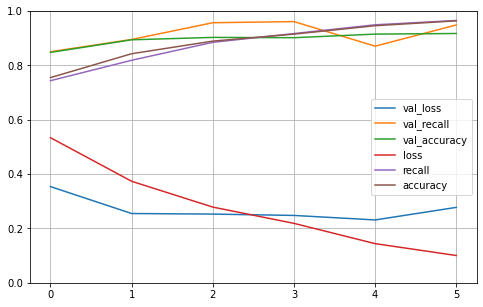

In [55]:
# history is a keras.callbacks.callbacks.History object
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [37]:
# DON'T RE-RUN
NUM_EPOCHS = 3
BATCH_SIZE = 32
INPUT_SHAPE = (BANDS, TIME_SLICES, 1)

# 2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 
# 61, 67, 71, 73, 79, 83, 89, 97, 101, 103, 107, 109, 113, 127, 
# 131, 137, 139, 149, 151, 157, 163, 167, 173, 179, 181, 191, 193, 
# 197, 199, 211, 223, 227, 229, 233, 239, 241, 251, 257, 263, 269, 271
model = Sequential()
model.add(Conv2D(31, kernel_size=(2, 2), activation='relu',
                 input_shape=INPUT_SHAPE))
model.add(Conv2D(47, kernel_size=(2, 2), activation='relu'))
model.add(Conv2D(71, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(127, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(127, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(53, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', 
              metrics=[Recall(name='recall'), 'accuracy'])
history = model.fit(x_train, y_train, epochs=NUM_EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    validation_split=VALIDATION_SIZE)

Train on 3620 samples, validate on 906 samples
Epoch 1/3
3620/3620 [==============================] - 457s 126ms/step - loss: 0.5227 - recall: 0.7949 - accuracy: 0.7773 - val_loss: 0.3886 - val_recall: 0.6982 - val_accuracy: 0.8289
Epoch 2/3
3620/3620 [==============================] - 416s 115ms/step - loss: 0.3313 - recall: 0.8393 - accuracy: 0.8669 - val_loss: 0.2606 - val_recall: 0.9035 - val_accuracy: 0.9040
Epoch 3/3
3620/3620 [==============================] - 397s 110ms/step - loss: 0.2439 - recall: 0.9022 - accuracy: 0.9083 - val_loss: 0.2579 - val_recall: 0.8604 - val_accuracy: 0.9018


In [38]:
# auc, 
loss, recall, accuracy = model.evaluate(x_test, y_test)
# print('AUC: %.2f' % (auc * 100))
print('Recall: %.2f' % (recall * 100))
print('Accuracy: %.2f' % (accuracy * 100))

1132/1132 [==============================] - 27s 24ms/step
Recall: 83.50
Accuracy: 89.31


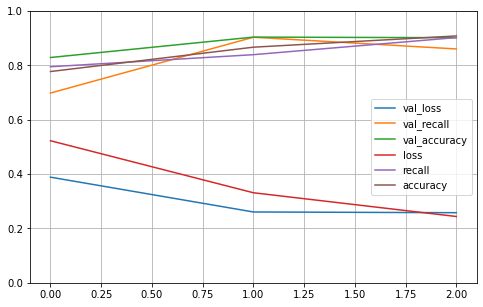

In [39]:
# history is a keras.callbacks.callbacks.History object
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

# Model D

In [81]:
NUM_EPOCHS = 12
BATCH_SIZE = 32
INPUT_SHAPE = (BANDS, TIME_SLICES, 1)

model = Sequential()
model.add(Conv2D(32, kernel_size=(2, 2), activation='relu',
                 input_shape=INPUT_SHAPE))
model.add(Conv2D(48, kernel_size=(2, 2), activation='relu'))
model.add(Conv2D(72, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', 
              metrics=[Recall(name='recall'), 'accuracy'])
history = model.fit(x_train, y_train, epochs=NUM_EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    validation_split=VALIDATION_SIZE)

Train on 3620 samples, validate on 906 samples
Epoch 1/12
3620/3620 [==============================] - 480s 132ms/step - loss: 0.5572 - recall: 0.7622 - accuracy: 0.7508 - val_loss: 0.3262 - val_recall: 0.8193 - val_accuracy: 0.8664
Epoch 2/12
3620/3620 [==============================] - 447s 123ms/step - loss: 0.3761 - recall: 0.8277 - accuracy: 0.8494 - val_loss: 0.2551 - val_recall: 0.8563 - val_accuracy: 0.9007
Epoch 3/12
3620/3620 [==============================] - 472s 130ms/step - loss: 0.2784 - recall: 0.8758 - accuracy: 0.8865 - val_loss: 0.2616 - val_recall: 0.8398 - val_accuracy: 0.9007
Epoch 4/12
3620/3620 [==============================] - 455s 126ms/step - loss: 0.2044 - recall: 0.9160 - accuracy: 0.9155 - val_loss: 0.2442 - val_recall: 0.8686 - val_accuracy: 0.9161
Epoch 5/12
3620/3620 [==============================] - 464s 128ms/step - loss: 0.1476 - recall: 0.9519 - accuracy: 0.9436 - val_loss: 0.2257 - val_recall: 0.9199 - val_accuracy: 0.9272
Epoch 6/12
3620/3620 [=

In [83]:
# auc, 
loss, recall, accuracy = model.evaluate(x_test, y_test)
# print('AUC: %.2f' % (auc * 100))
print('Recall: %.2f' % (recall * 100))
print('Accuracy: %.2f' % (accuracy * 100))
# @ 3 Epochs
# Recall: 86.44
# Accuracy: 90.19
# @ 6 Epochs
# Recall: 94.12
# Accuracy: 92.40
# @ 12 Epochs
# Recall: 
# Accuracy: 


1132/1132 [==============================] - 30s 26ms/step
Recall: 90.52
Accuracy: 90.28


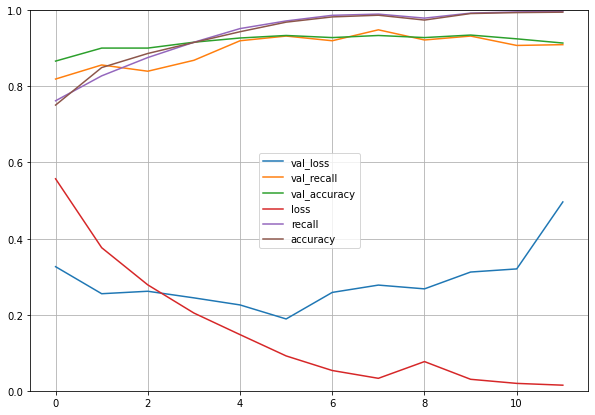

In [86]:
# history is a keras.callbacks.callbacks.History object
pd.DataFrame(history.history).plot(figsize=(10, 7))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [87]:
model.save('./keras_models/tenor_cnn_D.h5')

# Model E

In [59]:
NUM_EPOCHS = 6
BATCH_SIZE = 32
INPUT_SHAPE = (BANDS, TIME_SLICES, 1)

model = Sequential()
model.add(Conv2D(32, kernel_size=(2, 2), activation='relu',
                 input_shape=INPUT_SHAPE))
model.add(Conv2D(48, kernel_size=(2, 2), activation='relu'))
model.add(Conv2D(128, kernel_size=(2, 2), activation='relu'))
model.add(AveragePooling2D(pool_size=(2, 2)))  # If strides not set it defaults to pool size. OK.
model.add(Dropout(0.25))
model.add(Flatten())  # Flattens the input. Does not affect the batch size.
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', 
              metrics=[Recall(name='recall'), 'accuracy'])
history = model.fit(x_train, y_train, epochs=NUM_EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    validation_split=VALIDATION_SIZE)

Train on 3620 samples, validate on 906 samples
Epoch 1/6
3620/3620 [==============================] - 179s 49ms/step - loss: 0.5509 - recall: 0.7579 - accuracy: 0.7456 - val_loss: 0.3708 - val_recall: 0.8111 - val_accuracy: 0.8532
Epoch 2/6
3620/3620 [==============================] - 176s 49ms/step - loss: 0.3359 - recall: 0.8615 - accuracy: 0.8627 - val_loss: 0.2531 - val_recall: 0.8789 - val_accuracy: 0.8962
Epoch 3/6
3620/3620 [==============================] - 177s 49ms/step - loss: 0.2211 - recall: 0.9228 - accuracy: 0.9207 - val_loss: 0.2473 - val_recall: 0.8809 - val_accuracy: 0.9106
Epoch 4/6
3620/3620 [==============================] - 176s 49ms/step - loss: 0.1292 - recall: 0.9530 - accuracy: 0.9494 - val_loss: 0.2397 - val_recall: 0.9548 - val_accuracy: 0.9073
Epoch 5/6
3620/3620 [==============================] - 180s 50ms/step - loss: 0.0819 - recall: 0.9741 - accuracy: 0.9715 - val_loss: 0.2861 - val_recall: 0.9425 - val_accuracy: 0.9062
Epoch 6/6
3620/3620 [============

In [60]:
# auc, 
loss, recall, accuracy = model.evaluate(x_test, y_test)
# print('AUC: %.2f' % (auc * 100))
print('Recall: %.2f' % (recall * 100))
print('Accuracy: %.2f' % (accuracy * 100))
# @ 3 Epochs
# Recall: 86.93
# Accuracy: 90.81
# @ 6 Epochs
# Recall: 90.03
# Accuracy: 90.72

1132/1132 [==============================] - 10s 9ms/step
Recall: 90.03
Accuracy: 90.72


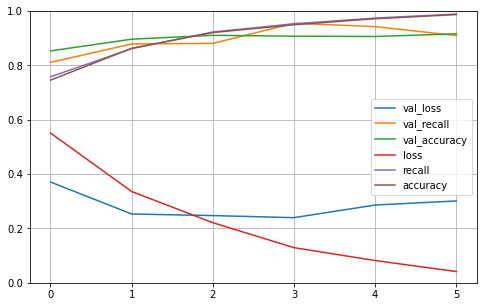

In [61]:
# history is a keras.callbacks.callbacks.History object
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [66]:
# DO NOT RE-RUN

NUM_EPOCHS = 3
BATCH_SIZE = 32
INPUT_SHAPE = (BANDS, TIME_SLICES, 1)

model = Sequential()
model.add(Conv2D(32, kernel_size=(2, 2), activation='relu',
                 input_shape=INPUT_SHAPE))
model.add(Conv2D(48, kernel_size=(2, 2), activation='relu'))
model.add(Conv2D(72, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))  # <<< Only change from model D
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', 
              metrics=[Recall(name='recall'), 'accuracy'])
history = model.fit(x_train, y_train, epochs=NUM_EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    validation_split=VALIDATION_SIZE)

Train on 3620 samples, validate on 906 samples
Epoch 1/3
3620/3620 [==============================] - 192s 53ms/step - loss: 0.4865 - recall: 0.7526 - accuracy: 0.7669 - val_loss: 0.2845 - val_recall: 0.8665 - val_accuracy: 0.8819
Epoch 2/3
3620/3620 [==============================] - 201s 55ms/step - loss: 0.3363 - recall: 0.8536 - accuracy: 0.8663 - val_loss: 0.2283 - val_recall: 0.9405 - val_accuracy: 0.9095
Epoch 3/3
3620/3620 [==============================] - 202s 56ms/step - loss: 0.2662 - recall: 0.8901 - accuracy: 0.8989 - val_loss: 0.2807 - val_recall: 0.8357 - val_accuracy: 0.9018


In [68]:
# auc, 
loss, recall, accuracy = model.evaluate(x_test, y_test)
# print('AUC: %.2f' % (auc * 100))
print('Recall: %.2f' % (recall * 100))
print('Accuracy: %.2f' % (accuracy * 100))
# @ 3 Epochs
# Recall: 83.01
# Accuracy: 89.75
# @ 6 Epochs
# 
#

1132/1132 [==============================] - 13s 11ms/step
Recall: 83.01
Accuracy: 89.75


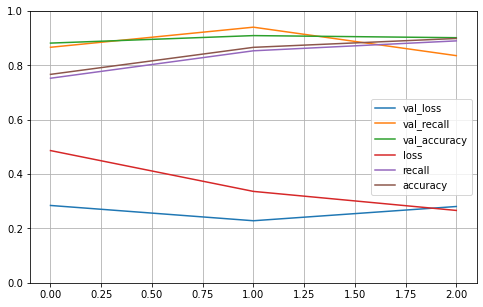

In [69]:
# history is a keras.callbacks.callbacks.History object
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [6]:
NUM_EPOCHS = 12
BATCH_SIZE = 32
INPUT_SHAPE = (BANDS, TIME_SLICES, 1)

model = Sequential()
model.add(Conv2D(32, kernel_size=(2, 2), activation='relu',
                 input_shape=INPUT_SHAPE))
model.add(MaxPooling2D(pool_size=(2, 2)))  # <<< Only change from model D
model.add(Conv2D(48, kernel_size=(2, 2), activation='relu'))
model.add(Conv2D(72, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
# model.add(Dense(1))
model.add(Dense(1, activation='softmax'))

# opt = Adam(learning_rate=0.01)
# Defaults for Adam
# tf.keras.optimizers.Adam(
#     learning_rate=0.001,
#     beta_1=0.9,
#     beta_2=0.999,
#     epsilon=1e-07,
#     amsgrad=False,
#     name="Adam",
#     **kwargs
# )
model.compile(loss='binary_crossentropy', optimizer='adam', 
              metrics=[Recall(name='recall'), 'accuracy'])  # , AUC(name='auc')
history = model.fit(x_train, y_train, epochs=NUM_EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    validation_split=VALIDATION_SIZE)

Train on 3620 samples, validate on 906 samples
Epoch 1/12
3620/3620 [==============================] - 244s 67ms/step - loss: 1.3595 - recall: 0.6047 - accuracy: 0.6072 - val_loss: 0.4281 - val_recall: 0.7372 - val_accuracy: 0.7914
Epoch 2/12
3620/3620 [==============================] - 142s 39ms/step - loss: 0.6648 - recall: 0.6781 - accuracy: 0.6633 - val_loss: 0.5266 - val_recall: 0.5175 - val_accuracy: 0.7241
Epoch 3/12
3620/3620 [==============================] - 125s 35ms/step - loss: 0.6132 - recall: 0.6919 - accuracy: 0.6486 - val_loss: 1.4362 - val_recall: 0.9240 - val_accuracy: 0.3962
Epoch 4/12
3620/3620 [==============================] - 129s 36ms/step - loss: 0.8242 - recall: 0.5830 - accuracy: 0.6077 - val_loss: 0.5700 - val_recall: 0.5092 - val_accuracy: 0.6998
Epoch 5/12
3620/3620 [==============================] - 131s 36ms/step - loss: 0.6552 - recall: 0.4683 - accuracy: 0.6519 - val_loss: 0.5526 - val_recall: 0.6858 - val_accuracy: 0.7660
Epoch 6/12
3620/3620 [======

In [7]:
# auc, 
loss, recall, accuracy = model.evaluate(x_test, y_test)  # , auc
# print('AUC: %.2f' % (auc * 100))
print('Recall: %.2f' % (recall * 100))
print('Accuracy: %.2f' % (accuracy * 100))
# @ 3 Epochs
# Recall: 83.33
# Accuracy: 87.72
# @ 6 Epochs
# Recall: 94.61
# Accuracy: 93.02
# @ 9 Epochs
# AUC: 97.68
# Recall: 94.28
# Accuracy: 93.11
# @ 12 Epochs
# Recall: 95.59
# Accuracy: 91.96
# ------------------
# AUC: 96.59
# Recall: 91.01
# Accuracy: 91.61
# ------------------
# No sigmoid; just sum in last layer
# Recall: 
# Accuracy: 

1132/1132 [==============================] - 8s 7ms/step
Recall: 100.00
Accuracy: 54.06


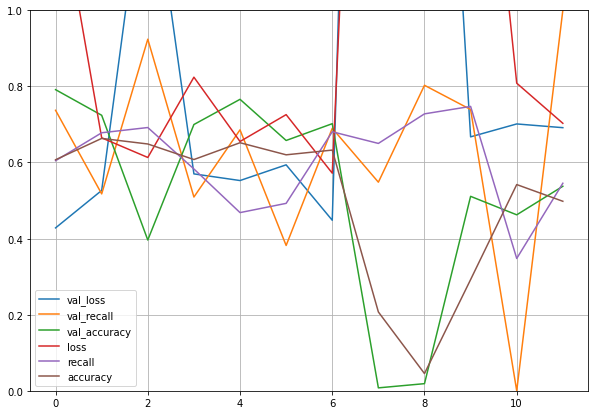

In [8]:
# history is a keras.callbacks.callbacks.History object
pd.DataFrame(history.history).plot(figsize=(10, 7))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [80]:
model.save('./keras_models/tenor_cnn_F_NO_SIGMOID.h5')